# Drive Operations

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
%pwd
%cd 'drive/My Drive/Workspaces/twitter_sentiment_analysis'

/content/drive/My Drive/Workspaces/twitter_sentiment_analysis


# Libraries

In [ ]:
! pip install transformers

In [80]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# EDA and Cleaning
1. Importing data
2. Exploring data
3. Cleaning data
4. Saving data

In [3]:
import pandas as pd

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [26]:
train_df['tweet'] = train_df['tweet'].str.replace('@user','')

## Target distribution

In [27]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

There is a target imbalance in the data.
Need to be handled later on.

In [28]:
train_df.tweet.isnull().any()

False

There is no missing data present

### Since it is twitter data. Hashtags are important.
Get the hashtags and analyse the effect.

In [29]:
train_df['hashtags'] = train_df.tweet.apply(lambda tweet: ','.join([word[1:] for word in tweet.split() if '#' == word[0]]))

In [30]:
no_hashtags = train_df[train_df.hashtags == ''].hashtags.count()
hashtags = train_df[~(train_df.hashtags == '')].hashtags.count()
print('{}% of tweets have hashtags.'.format(round(100*(hashtags/(hashtags + no_hashtags)),2)))

72.98% of tweets have hashtags.


In [31]:
train_df[train_df.hashtags == ''].label.value_counts()

0    8024
1     613
Name: label, dtype: int64

In [32]:
train_df[~(train_df.hashtags == '')].hashtags.count()

23325

## Data Cleaning

In [64]:
train_df['cleaned_tweet'] = train_df['tweet']

In [65]:
#Remove URLs
train_df['cleaned_tweet'] = train_df.cleaned_tweet.apply(lambda tweet : ' '.join([word for word in tweet.split() if not 'www' in word and not '.co' in word]))

In [ ]:
!pip install contractions

In [66]:
#Expand contractions
import contractions
train_df['cleaned_tweet'] = train_df['cleaned_tweet'].apply(lambda tweet: contractions.fix(tweet).lower())

In [67]:
# Remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
train_df['cleaned_tweet'] = train_df['cleaned_tweet'].apply(lambda tweet: ' '.join([word for word in tweet.split() if not word in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# Remove junk characters - encode and decode
train_df['cleaned_tweet'] = train_df.cleaned_tweet.apply(lambda tweet : tweet.encode('ascii','ignore').decode('ascii'))

In [69]:
#Remove punctuations
import re
train_df['cleaned_tweet'] = train_df.cleaned_tweet.apply(lambda tweet : re.sub(r'[^\w\s]','',tweet))

## Arranging input for BERT

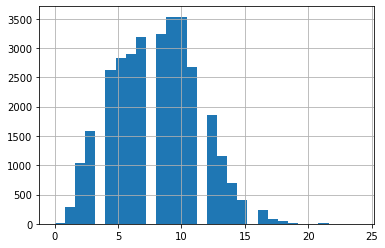

In [73]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df.cleaned_tweet]

pd.Series(seq_len).hist(bins = 30)

Keeping the padding length as 24.


24

In [77]:
test_list = train_df.head(10).cleaned_tweet.tolist()
test_list

['father dysfunctional selfish drags kids dysfunction run',
 'thanks lyft credit use offer wheelchair vans pdx disapointed getthanked',
 'bihday majesty',
 'model love take time ur  ',
 'factsguide society motivation',
 '22 huge fan fare big talking leave chaos pay disputes get there allshowandnogo',
 'camping tomorrow danny',
 'next school year year exams think  school exams hate imagine actorslife revolutionschool girl',
 'won love land allin cavs champions cleveland clevelandcavaliers ',
 'welcome  gr8 ']